# Batting Average Analysis
## For the start(ish) of the 2017 season
### MSP 04.29.2017

This jupyter notebook lays out some for for investigating average projections in 2017.

Full disclosure: I assumed going into this season that I'd be able to win batting average solely by picking an entire team of above-average batting average guys. Let's see how that belief holds up through this analysis...

### Part II: Hits

What constitutes a hit, anyway? Statcast is the new shiny toy of the analytics community, so let's get in on it.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from random import randrange
import scipy.stats as sst




In [3]:
# now read in all the data: it's a lot, but is set up this way so that
#  we can slice across batting order.

#
# general fangraphs data for players
#
# all with > 100 PA at given lineup position

def read_batting_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG","playerid"),\
                         'formats': ('S20','S20','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4','i2')},\
                 skip_header=1,delimiter=',')
    return BatData


def read_individual_game_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Date","Team","Opp","BO","Pos","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG"),\
                         'formats': ('S20','S20','S20','i2','S4','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4')},\
                 skip_header=2,delimiter=',')
    return BatData


Beltre2016 = read_individual_game_data('2016Batting/BeltreLog2016.csv')
Trout2016 = read_individual_game_data('2016Batting/TroutLog2016.csv')

Altuve2016 = read_individual_game_data('2016Batting/AltuveLog2016.csv')
Altuve2017 = read_individual_game_data('2016Batting/AltuveLog2017.csv')


Lemahieu2016 = read_individual_game_data('2016Batting/LemahieuLog2016.csv')
Lemahieu2017 = read_individual_game_data('2016Batting/LemahieuLog2017.csv')



Total2016   = read_batting_data('2016Batting/TotalBatting.csv')



# the spreadsheet below has been adjusted to skip 'des', which routinely has commas. C'mon guys! This needs to be machine readable!
def read_statcast_data(infile):
    outdict = np.genfromtxt(infile,\
        dtype={'names': ("pitch_type","game_date",\
                         "release_speed","x0","z0","player_name","batter","pitcher",\
                         "events","description","spin_dir","spin_rate","break_angle",\
                         "break_length","zone","game_type","stand","p_throws",\
                         "home_team","away_team","type","hit_location","bb_type",\
                         "balls","strikes","game_year","pfx_x","pfx_z","px","pz",\
                         "on_3b","on_2b","on_1b","outs_when_up","inning","inning_topbot",\
                         "hc_x","hc_y","tfs","tfs_zulu","catcher","umpire","sv_id",\
                         "vx0","vy0","vz0","ax","ay","az","sz_top","sz_bot","hit_distance_sc",\
                         "launch_speed","launch_angle","effective_speed","release_spin_rate",\
                         "release_extension","game_pk",\
                         "pos1_id","pos2_id","pos3_id",\
                         "pos4_id","pos5_id","pos6_id",\
                         "pos7_id","pos8_id","pos9_id",\
                         "release_pos_y","estimated_ba_using_speedangle","estimated_woba_using_speedangle",\
                         "woba_value","woba_denom","babip_value","iso_value"),\
                'formats': ('S2','S20',\
                            'f4','S20','S20','S20','S20','S20',\
                            'S40','S40','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20','S20','S20',\
                            'f4','f4','f4','f4',
                            'S20','S20',\
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4','f4')},\
                 skip_header=1,delimiter=',')
    return outdict


AugustHits = read_statcast_data('2016Batting/August2016Hits.csv')

AugustOuts = read_statcast_data('2016Batting/August2016Outs.csv')






A month ago we looked at what it took to make a home run in terms of launch angle and launch velocity (cue discussion of the statcast changeover). This is a plot of relative hit frequency (hits/outs) in the launch angle/launch velocity plane. 

Can we learn anything from looking at this?

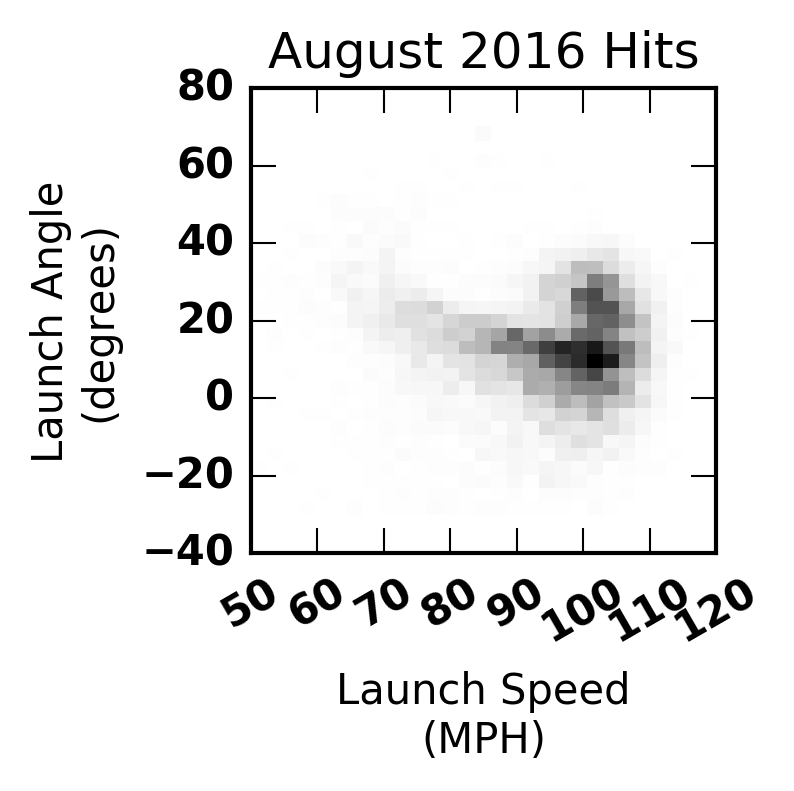

In [4]:

xbins = np.linspace(50.,120.,30)
ybins = np.linspace(-30.,70.,30)

ghits = np.where( (AugustHits['launch_speed'] != 90) | (AugustHits['launch_angle'] > 0))[0]

H, xedges, yedges = np.histogram2d(AugustHits['launch_speed'][ghits],AugustHits['launch_angle'][ghits], \
                                   bins=(xbins,ybins))
H = H.T/np.sum(H) # Let each row list bins with common y range.


ghits = np.where( (AugustOuts['launch_speed'] != 90) | (AugustOuts['launch_angle'] > 0))[0]

G, xedges, yedges = np.histogram2d(AugustOuts['launch_speed'][ghits],AugustOuts['launch_angle'][ghits], \
                                   bins=(xbins,ybins))
G = G.T/np.sum(G)  # Let each row list bins with common y range.



fig,ax = plt.subplots(figsize=(2,2))
ax.set_title('August 2016 Hits')
X, Y = np.meshgrid(xedges, yedges)
X2, Y2 = np.meshgrid(xbins,ybins)
ax.pcolormesh(X, Y, H/(G+1.),cmap=cm.Greys)
ax.set_ylabel('Launch Angle\n(degrees)')
ax.set_xlabel('Launch Speed\n(MPH)')

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")



It seems like yes. I see two clear tracks in this plot, one where if you it it harder it's okay that the launch angle decreases, and by that same token, if you hit it hard enough, you've got a good shot at a hit no matter the angle (up to some tolerance, in this case about 40$^\circ$).

It's safe to roughly think of these as the single and extra base-hit tracks, and could be a jumping off point for some future analysis. For now, let's move on.



### Ks and Walks

...do not appear to affect the number of hits. Here, I'm plotting (in the upper panel) 2016 hits versus 2016 strikeouts, and in the lower panel, 2016 hits versus 2016 walks.


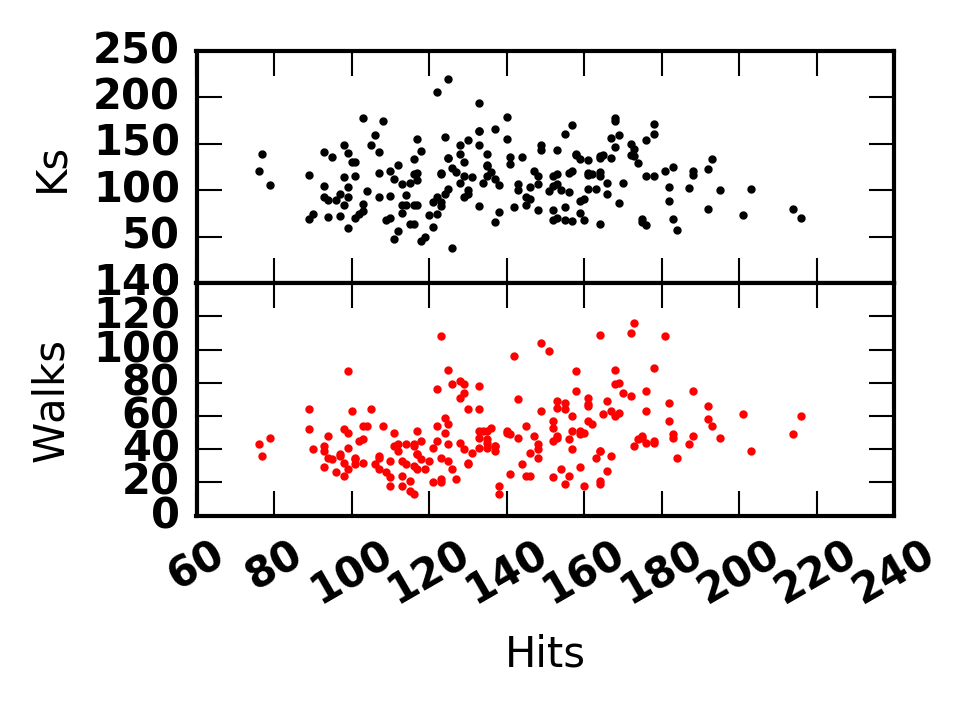

In [5]:
hs = Total2016['H']
pas = Total2016['PA']
sos = Total2016['SO']
bbs = Total2016['BB']
names = Total2016['Name']

g_pas = np.where(pas>400)[0]


fig = plt.figure(figsize=(3,2))

plt.subplots_adjust(hspace=0.001)

ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.scatter(hs[g_pas],sos[g_pas],color='black',s=1.)
#ax.text(80,0.93,'Walks',size=8)


#ax.axis([0.,120.,0.75,1.0])
ax.set_ylabel('Ks')
ax.set_xticklabels(())

ax2.scatter(hs[g_pas],bbs[g_pas],color='red',s=1.)
#ax2.axis([0.,120.,0.75,1.0])
#ax2.text(80,0.93,'Sacrifices',color='red',size=8)

ax2.set_ylabel('Walks')
_ = ax2.set_xlabel('Hits')

for label in ax2.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")





I have to say, I expected trends. I thought the top plot would show that an increase in strikeouts meant fewer hits, while an increasing walks meant more hits--sort of a 'how good is your eye' test.

However, neither appears to show much (if any) of a trend. What to make of this?

### The Revised Game Plan

It doesn't appear that we can currently understand theoretically what increases a batter's hits, either from PA outcomes or how the ball was hit. Perhaps we're losing something in the ensemble average.

Therefore, it's time for some Monte Carlo!

Revisiting our old friends from last week, I've simulated batting average in a given 7 game stretch.


----Beltre----
Mean:  0.288201166792
Sigma:  0.0962391368221
Skew:  -0.720148355771
SkewSigma:  -24.1209492415
----Lemahieu----
Mean:  0.332046109188
Sigma:  0.107691605786
Skew:  -0.781391021378
SkewSigma:  -22.1103510237
----Altuve----
Mean:  0.325607241855
Sigma:  0.119311653224
Skew:  -0.678440240968
SkewSigma:  -16.4621784263
----Trout----
Mean:  0.304818231945
Sigma:  0.106102753578
Skew:  -0.279906025143
SkewSigma:  -8.09882966078


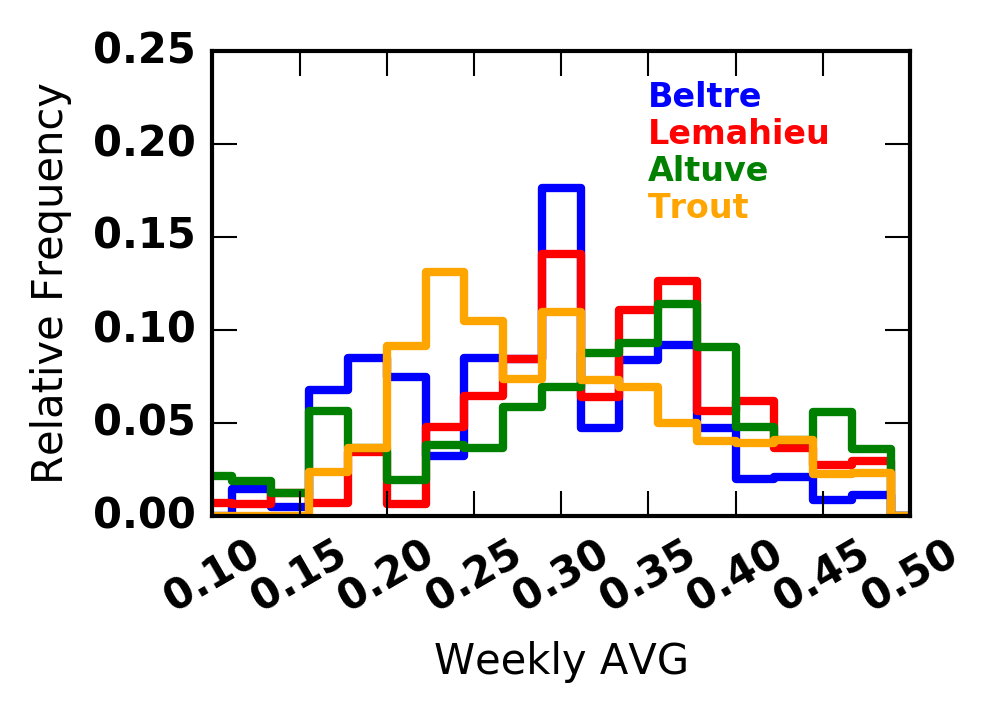

In [6]:


def avg_simulate(PlayerNotebook,Stat='AB',bins=np.linspace(.100,.500,19),nsims=10000,verbose=1,ngames=7):
    
    vals = np.zeros(bins.shape[0])
    
    tvals = np.zeros(nsims)
    
    for indx in range(0,nsims):
        
        random_index = randrange(0,len(PlayerNotebook[Stat]))
        if random_index > len(PlayerNotebook[Stat])-ngames:
            continue
            
        avg = np.sum(PlayerNotebook['H'][random_index:random_index+ngames])/np.sum(PlayerNotebook['AB'][random_index:random_index+ngames])
        
        bpos = (avg - bins[0])/(bins[1]-bins[0])
        
        if (bpos > 0) & (bpos < len(bins)-1):
            vals[bpos] += 1
        tvals[indx] = avg
    
    if verbose:
        print 'Mean: ',np.mean(tvals)
        print 'Sigma: ',np.std(tvals)
        print 'Skew: ',sst.skew(tvals)
        print 'SkewSigma: ',sst.skew(tvals)/np.std(tvals)**1.5

    return bins,vals,tvals


ngames = 7
print '----Beltre----'
BeltreB,BeltreV,BeltreT = avg_simulate(Beltre2016,ngames=ngames)

print '----Lemahieu----'
LemahieuB,LemahieuV,LemahieuT = avg_simulate(Lemahieu2016,ngames=ngames)

print '----Altuve----'
AltuveB,AltuveV,AltuveT = avg_simulate(Altuve2016,ngames=ngames)

print '----Trout----'
TroutB,TroutV,TroutT = avg_simulate(Trout2016,ngames=ngames)





fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.plot(BeltreB,BeltreV/10000.,drawstyle='steps-mid',color='blue')
ax.plot(LemahieuB,LemahieuV/10000.,drawstyle='steps-mid',color='red')
ax.plot(AltuveB,AltuveV/10000.,drawstyle='steps-mid',color='green')
ax.plot(TroutB,TroutV/10000.,drawstyle='steps-mid',color='orange')

ax.text(0.35,0.22,'Beltre',color='blue',size=8)
ax.text(0.35,0.2,'Lemahieu',color='red',size=8)
ax.text(0.35,0.18,'Altuve',color='green',size=8)
ax.text(0.35,0.16,'Trout',color='orange',size=8)



ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Weekly AVG')
_ = ax.axis([.100,.5,0.,0.25])

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")




#4.21 PA/game for average 5 hitter

Quick hits:

1. **Adrian Beltre**, rock steady just under .300.
2. **Mike Trout**, bringing up the rear
3. **DJ Lemahieu** doesn't really have bad weeks.
4. **Jose Altuve** could give you anything between .150 and .500 in a week.

----Beltre----
Mean:  7.7342
Sigma:  2.70236014624
Skew:  -0.531126828411
SkewSigma:  -0.119559309472
----Lemahieu----
Mean:  8.7804
Sigma:  3.0998993274
Skew:  -0.397432333177
SkewSigma:  -0.0728185139017
----Altuve----
Mean:  9.0774
Sigma:  3.42604863363
Skew:  -0.521997901724
SkewSigma:  -0.0823149032145
----Trout----
Mean:  7.4375
Sigma:  2.98735564505
Skew:  0.287479854363
SkewSigma:  0.0556771534501


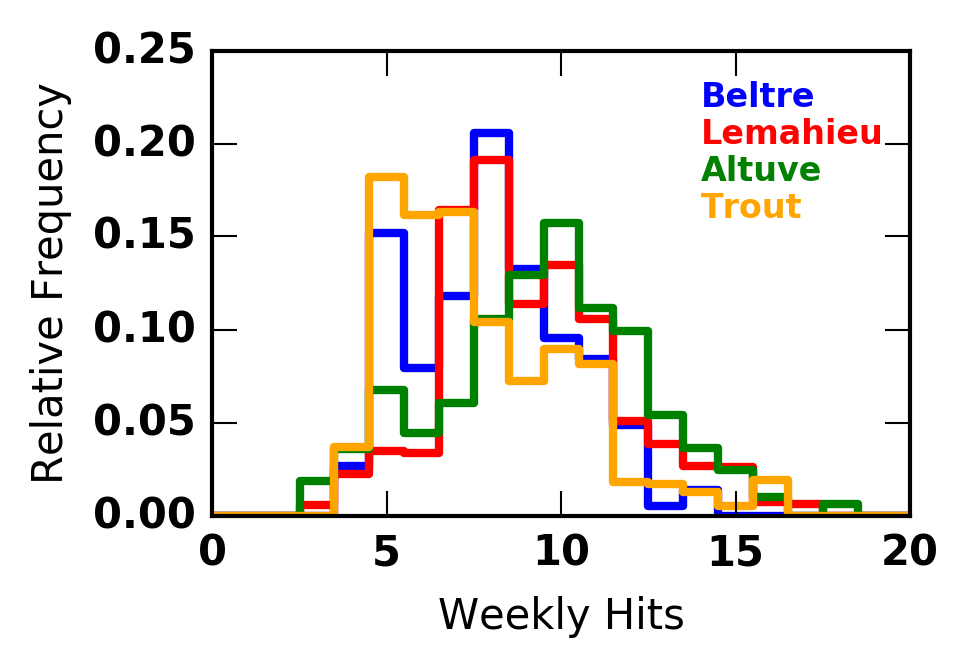

In [7]:


def ab_simulate(PlayerNotebook,Stat='AB',bins=np.arange(0,45,1),nsims=10000,verbose=1,ngames=7):
    
    vals = np.zeros(bins.shape[0])
    
    tvals = np.zeros(nsims)
    
    for indx in range(0,nsims):
        
        random_index = randrange(0,len(PlayerNotebook[Stat]))
        if random_index > len(PlayerNotebook[Stat])-ngames:
            continue
            
        vals[np.sum(PlayerNotebook[Stat][random_index:random_index+ngames])] += 1
        tvals[indx] = np.sum(PlayerNotebook[Stat][random_index:random_index+ngames])
    
    if verbose:
        print 'Mean: ',np.mean(tvals)
        print 'Sigma: ',np.std(tvals)
        print 'Skew: ',sst.skew(tvals)
        print 'SkewSigma: ',sst.skew(tvals)/np.std(tvals)**1.5

    return bins,vals,tvals

print '----Beltre----'
BeltreB,BeltreV,BeltreT = ab_simulate(Beltre2016,Stat='H')

print '----Lemahieu----'
LemahieuB,LemahieuV,LemahieuT = ab_simulate(Lemahieu2016,Stat='H')

print '----Altuve----'
AltuveB,AltuveV,AltuveT = ab_simulate(Altuve2016,Stat='H')

print '----Trout----'
TroutB,TroutV,TroutT = ab_simulate(Trout2016,Stat='H')





plt.figure(figsize=(3,2))
plt.plot(BeltreB,BeltreV/10000.,drawstyle='steps-mid',color='blue')
plt.plot(LemahieuB,LemahieuV/10000.,drawstyle='steps-mid',color='red')
plt.plot(AltuveB,AltuveV/10000.,drawstyle='steps-mid',color='green')
plt.plot(TroutB,TroutV/10000.,drawstyle='steps-mid',color='orange')

plt.text(14,0.22,'Beltre',color='blue',size=8)
plt.text(14,0.2,'Lemahieu',color='red',size=8)
plt.text(14,0.18,'Altuve',color='green',size=8)
plt.text(14,0.16,'Trout',color='orange',size=8)



plt.ylabel('Relative Frequency')
plt.xlabel('Weekly Hits')
_ = plt.axis([0.0,20.,0.,0.25])


#4.21 PA/game for average 5 hitter

Interestingly, this is of course the plot you really want to be maximizing in order to drive your team average up. Mike Trout is not the guy who is going to drive your team average up--DJ Lemahieu and Jose Altuve are.

### Takeaways

1. Watch the raw number of hits for impact on your batting average, but watch the PA number for adjustments as to the impact.
2. If you want to check whether hits are legit, use the statcast template above.
3. Walks and Ks are not affecting average to a large extent--trust your guy's stats without Ks and BBs taken into consideration.

### Appendix: 6 v. 7 game weeks

You may have noticed that I got cagier with what I called a 'week'. That's because there is actually a lot of volatility that sets in between a 6 and 7 game week. For instance, the above plot is a 7-game week, this is the corresponding 6 game week plot:

----Beltre----
Mean:  0.287589471068
Sigma:  0.100951592875
Skew:  -0.576330481972
SkewSigma:  -17.9680863517
----Lemahieu----
Mean:  0.331753855391
Sigma:  0.112300723037
Skew:  -0.564564929256
SkewSigma:  -15.0016858838
----Altuve----
Mean:  0.328997949774
Sigma:  0.123602398009
Skew:  -0.50764687311
SkewSigma:  -11.6821121333
----Trout----
Mean:  0.305094601905
Sigma:  0.108008357924
Skew:  -0.0394383336079
SkewSigma:  -1.11104720505


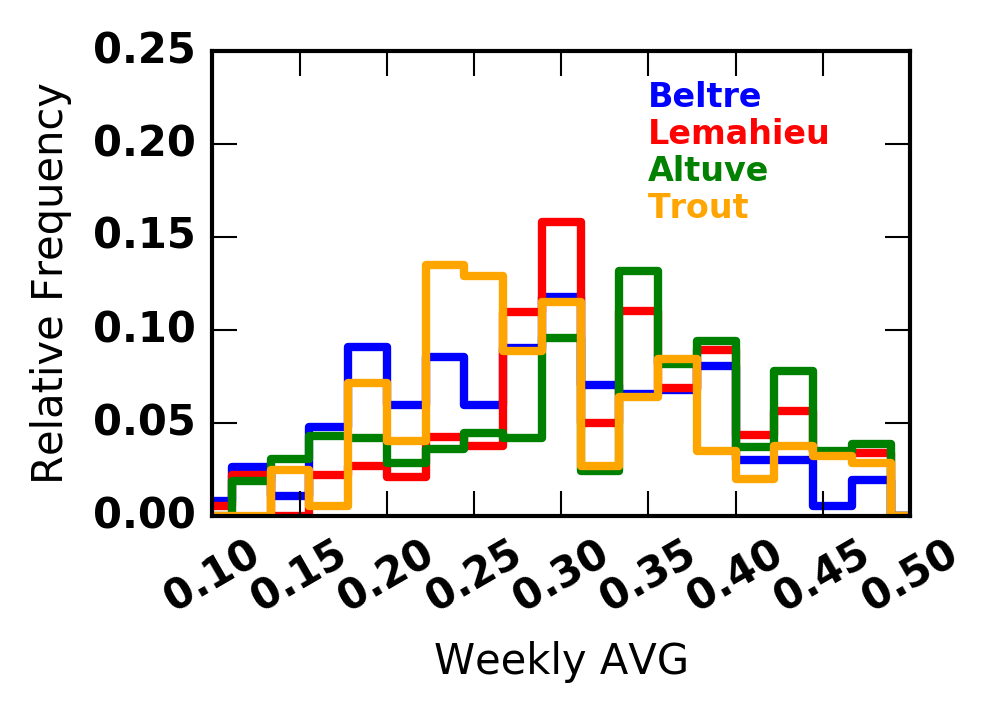

In [8]:
ngames = 6
print '----Beltre----'
BeltreB,BeltreV,BeltreT = avg_simulate(Beltre2016,ngames=ngames)

print '----Lemahieu----'
LemahieuB,LemahieuV,LemahieuT = avg_simulate(Lemahieu2016,ngames=ngames)

print '----Altuve----'
AltuveB,AltuveV,AltuveT = avg_simulate(Altuve2016,ngames=ngames)

print '----Trout----'
TroutB,TroutV,TroutT = avg_simulate(Trout2016,ngames=ngames)





fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.plot(BeltreB,BeltreV/10000.,drawstyle='steps-mid',color='blue')
ax.plot(LemahieuB,LemahieuV/10000.,drawstyle='steps-mid',color='red')
ax.plot(AltuveB,AltuveV/10000.,drawstyle='steps-mid',color='green')
ax.plot(TroutB,TroutV/10000.,drawstyle='steps-mid',color='orange')

ax.text(0.35,0.22,'Beltre',color='blue',size=8)
ax.text(0.35,0.2,'Lemahieu',color='red',size=8)
ax.text(0.35,0.18,'Altuve',color='green',size=8)
ax.text(0.35,0.16,'Trout',color='orange',size=8)



ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Weekly AVG')
_ = ax.axis([.100,.5,0.,0.25])

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")




Jose Altuve benefits the most from this switch--his average rises a 4 whole points (no small feat). That alone is telling us something about his streaky-ness, and as we learned last week, some of the average variation could definitely be being driven by the denominator.